# Assignment 6: Apply NB 

<ol>
    <li>Minimum data points need to be considered for people having 4GB RAM is <strong>50k</strong> and for 8GB RAM is <strong>100k</strong></li>
    <li>When you are using ramdomsearchcv or gridsearchcv you need not split the data into X_train,X_cv,X_test. As the above methods use kfold. The model will learn better if train data is more so splitting to X_train,X_test will suffice.</li>
    <li>If you are writing for loops to tune your model then you need split the data into X_train,X_cv,X_test.</li>
    <li>While splitting the data explore stratify parameter. </li>
    <li><strong>Apply Multinomial NB on these feature sets</strong></li>
        <ul>
            <li>Features that need to be considered</li> 
                <dl>
                  <dt>essay</dt>
                    <dd>while encoding essay, try to experiment with the max_features and n_grams parameter of vectorizers and see if it increases AUC score.</dd>
                  <dt>categorical features</dt>
                  <dd> - teacher_prefix</dd>
                  <dd> - project_grade_category</dd>
                  <dd> - school_state</dd>
                  <dd> - clean_categories</dd>
                  <dd> - clean_subcategories</dd>
                  <dt>numerical features</dt>
                  <dd> - price</dd>
                  <dd> - teacher_number_of_previously_posted_projects</dd>
                  <dd>while encoding the numerical features check <a href='https://imgur.com/ldZA1zg'>this</a> and <a href='https://ac-classroom-production.s3.amazonaws.com/public/COMMENT/Annotation_2020-05-21_225912_0lyZzN8.jpg'>this</a></dd>
                </dl>    
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Consider alpha values in range: 10^-5 to 10^2 like [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]</li>
    <li>Explore class_prior = [0.5, 0.5] parameter which can be present in MultinomialNB function(go through <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>this</a> ) then check how results might change.
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>For hyper parameter tuning using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px><dd>-while plotting take log(alpha) on your X-axis so that it will be more readable</dd></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://imgur.com/q2P65L5.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
        <img src='https://i.imgur.com/IdN5Ctv.png' width=300px><dd>-plot the confusion matrix in heatmaps, while plotting the confusion matrix go through the <a href='https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor'>link </a>
</dd></li>
        </ul>
<li>find the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print <strong>BOTH</strong> positive as well as negative corresponding feature names. <dd> - go through the <a href='https://imgur.com/mWvE7gj'>link </a> </dd>
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

## 1. Importing Required Packages

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

import pickle
from tqdm import tqdm
import os

from chart_studio import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

## 2. Naive Bayes

## 2.1 Loading Data 

In [ ]:
#make sure you are loading atleast 50k datapoints
#you can work with features of preprocessed_data.csv for the assignment.
# If you want to add more features, you can add. (This is purely optional, not mandatory)

import pandas
data = pandas.read_csv('preprocessed_data.csv', nrows=50000)
data.head(5)

school_state teacher_prefix project_grade_category  \
0           ca            mrs          grades_prek_2   
1           ut             ms             grades_3_5   
2           ca            mrs          grades_prek_2   
3           ga            mrs          grades_prek_2   
4           wa            mrs             grades_3_5   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                            53                    1   
1                                             4                    1   
2                                            10                    1   
3                                             2                    1   
4                                             2                    1   

    clean_categories                 clean_subcategories  \
0       math_science  appliedsciences health_lifescience   
1       specialneeds                        specialneeds   
2  literacy_language                            literacy   
3    appliedlearning                    earlydevelopment   
4  literacy_language                            literacy   

                                               essay   price  
0  i fortunate enough use fairy tale stem kits cl...  725.05  
1  imagine 8 9 years old you third grade classroo...  213.03  
2  having class 24 students comes diverse learner...  329.00  
3  i recently read article giving students choice...  481.04  
4  my students crave challenge eat obstacles brea...   17.74

## 2.2 Splitting data into Train and cross validation(or test): Stratified Sampling

In [ ]:
#DROP THE CLASS LABEL
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)

#Split the Dataset into TRAIN and TEST (for Randomized Search CV)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv= train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

## 2.3 Make Data Model Ready: encoding essay

### 2.3.1 BOW

In [ ]:
# Apply Bag of Words (BOW) vectorization on 'Preprocessed_Essay' 

print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)
print("="*100)

(22445, 8) (22445,)
(11055, 8) (11055,)
(16500, 8) (16500,)


In [ ]:
#FITTING FOR DIFFERENT VALUES OF MAXIMUM NUMBER OF FEATURES, WITH ngram_range=(1,4)
#USING CountVectorizer Function
#1000
vectorizer_1 = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=1000)
vectorizer_1.fit(X_train['essay'].values) # fit has to happen only on train data

#2000
vectorizer_2 = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=2000)
vectorizer_2.fit(X_train['essay'].values) # fit has to happen only on train data

#5000
vectorizer_3 = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer_3.fit(X_train['essay'].values) # fit has to happen only on train data

#8000
vectorizer_4 = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=8000)
vectorizer_4.fit(X_train['essay'].values) # fit has to happen only on train data

CountVectorizer(max_features=8000, min_df=10, ngram_range=(1, 4))

In [ ]:
#TRANSFORMING THE DATA AFTER FITTING (FOR DIFFERENT NUMBER OF FEATURES WITH ngram_range=(1,4))
#1000 Features

X_train_essay_bow_a = vectorizer_1.transform(X_train['essay'].values)
X_cv_essay_bow_a = vectorizer_1.transform(X_cv['essay'].values)
X_test_essay_bow_a = vectorizer_1.transform(X_test['essay'].values)

#2000 Features
X_train_essay_bow_b = vectorizer_2.transform(X_train['essay'].values)
X_cv_essay_bow_b = vectorizer_2.transform(X_cv['essay'].values)
X_test_essay_bow_b = vectorizer_2.transform(X_test['essay'].values)

#5000 Features
X_train_essay_bow_c = vectorizer_3.transform(X_train['essay'].values)
X_cv_essay_bow_c = vectorizer_3.transform(X_cv['essay'].values)
X_test_essay_bow_c = vectorizer_3.transform(X_test['essay'].values)

#8000 Features
X_train_essay_bow_d = vectorizer_4.transform(X_train['essay'].values)
X_cv_essay_bow_d = vectorizer_4.transform(X_cv['essay'].values)
X_test_essay_bow_d = vectorizer_4.transform(X_test['essay'].values)


In [ ]:
#PRINTING THE SHAPES OF ALL BOWs

print("After vectorization for 1000 features. n-gram range = [1,4]")
print("Train=")
print(X_train_essay_bow_a.shape, y_train.shape)
print("CV=")
print(X_cv_essay_bow_a.shape, y_cv.shape)
print("Test=")
print(X_test_essay_bow_a.shape, y_test.shape)
print("="*100)

print("After vectorization for 2000 features, n-gram range = [1,4]")
print("Train=")
print(X_train_essay_bow_b.shape, y_train.shape)
print("CV=")
print(X_cv_essay_bow_b.shape, y_cv.shape)
print("Test=")
print(X_test_essay_bow_b.shape, y_test.shape)
print("="*100)

print("After vectorization for 5000 features, n-gram range = [1,4]")
print("Train=")
print(X_train_essay_bow_c.shape, y_train.shape)
print("CV=")
print(X_cv_essay_bow_c.shape, y_cv.shape)
print("Test=")
print(X_test_essay_bow_c.shape, y_test.shape)
print("="*100)

print("After vectorization for 8000 features, n-gram range = [1,4]")
print("Train=")
print(X_train_essay_bow_d.shape, y_train.shape)
print("CV=")
print(X_cv_essay_bow_d.shape, y_cv.shape)
print("Test=")
print(X_test_essay_bow_d.shape, y_test.shape)
print("="*100)

After vectorization for 1000 features. n-gram range = [1,4]
Train=
(22445, 1000) (22445,)
CV=
(11055, 1000) (11055,)
Test=
(16500, 1000) (16500,)
After vectorization for 2000 features, n-gram range = [1,4]
Train=
(22445, 2000) (22445,)
CV=
(11055, 2000) (11055,)
Test=
(16500, 2000) (16500,)
After vectorization for 5000 features, n-gram range = [1,4]
Train=
(22445, 5000) (22445,)
CV=
(11055, 5000) (11055,)
Test=
(16500, 5000) (16500,)
After vectorization for 8000 features, n-gram range = [1,4]
Train=
(22445, 8000) (22445,)
CV=
(11055, 8000) (11055,)
Test=
(16500, 8000) (16500,)


#### Trying out with different ngram ranges

In [ ]:
# Features= 5000, ngram_range=(1,2)
vectorizer_x= CountVectorizer(ngram_range=(1,2),min_df=10,max_features=5000)
vectorizer_x.fit(X_train['essay'].values) # fit has to happen only on train data
X_train_essay_bow_e = vectorizer_x.transform(X_train['essay'].values)
X_cv_essay_bow_e = vectorizer_x.transform(X_cv['essay'].values)
X_test_essay_bow_e = vectorizer_x.transform(X_test['essay'].values)

# Features= 8000, ngram_range=(1,2)
vectorizer_y= CountVectorizer(ngram_range=(1,2),min_df=10,max_features=8000)
vectorizer_y.fit(X_train['essay'].values) # fit has to happen only on train data
X_train_essay_bow_f = vectorizer_y.transform(X_train['essay'].values)
X_cv_essay_bow_f = vectorizer_y.transform(X_cv['essay'].values)
X_test_essay_bow_f = vectorizer_y.transform(X_test['essay'].values)

# Features= 8000, ngram_range=(1,5)
vectorizer_z= CountVectorizer(ngram_range=(1,5),min_df=10,max_features=8000)
vectorizer_z.fit(X_train['essay'].values) # fit has to happen only on train data
X_train_essay_bow_g = vectorizer_z.transform(X_train['essay'].values)
X_cv_essay_bow_g = vectorizer_z.transform(X_cv['essay'].values)
X_test_essay_bow_g = vectorizer_z.transform(X_test['essay'].values)

In [ ]:
print("After vectorization for 5000 features, n-gram range = [1,2]")
print("Train=")
print(X_train_essay_bow_e.shape, y_train.shape)
print("CV=")
print(X_cv_essay_bow_e.shape, y_cv.shape)
print("Test=")
print(X_test_essay_bow_e.shape, y_test.shape)
print("="*100)

print("After vectorization for 8000 features, n-gram range = [1,2]")
print("Train=")
print(X_train_essay_bow_f.shape, y_train.shape)
print("CV=")
print(X_cv_essay_bow_f.shape, y_cv.shape)
print("Test=")
print(X_test_essay_bow_f.shape, y_test.shape)
print("="*100)

print("After vectorization for 8000 features, n-gram range = [1,5]")
print("Train=")
print(X_train_essay_bow_g.shape, y_train.shape)
print("CV=")
print(X_cv_essay_bow_g.shape, y_cv.shape)
print("Test=")
print(X_test_essay_bow_g.shape, y_test.shape)
print("="*100)

After vectorization for 5000 features, n-gram range = [1,2]
Train=
(22445, 5000) (22445,)
CV=
(11055, 5000) (11055,)
Test=
(16500, 5000) (16500,)
After vectorization for 8000 features, n-gram range = [1,2]
Train=
(22445, 8000) (22445,)
CV=
(11055, 8000) (11055,)
Test=
(16500, 8000) (16500,)
After vectorization for 8000 features, n-gram range = [1,5]
Train=
(22445, 8000) (22445,)
CV=
(11055, 8000) (11055,)
Test=
(16500, 8000) (16500,)


### 2.3.2 TFIDF

In [ ]:
# Apply TF-IDF vectorization on 'Preprocessed_Essay' for different number of maximum features and ngram_range=(1,4)
#Using TfidfVectorizer()

preprocessed_essays_train= X_train['essay'].values
preprocessed_essays_cv= X_cv['essay'].values
preprocessed_essays_test= X_test['essay'].values

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_5 = TfidfVectorizer(ngram_range=(1,4),min_df=10, max_features=1000)
vectorizer_6 = TfidfVectorizer(ngram_range=(1,4),min_df=10, max_features=2000)
vectorizer_7 = TfidfVectorizer(ngram_range=(1,4),min_df=10, max_features=5000)
vectorizer_8 = TfidfVectorizer(ngram_range=(1,4),min_df=10, max_features=8000)

print("Shape After TFIDF Vectorization")

print("After vectorization for 1000 features, n-gram range = [1,4]")
print("Train=")
text_tfidf_train_1 = vectorizer_5.fit_transform(preprocessed_essays_train) #fit is done only on train data
print(text_tfidf_train_1.shape, y_train.shape)
print("CV=")
text_tfidf_cv_1 = vectorizer_5.transform(preprocessed_essays_cv) 
print(text_tfidf_cv_1.shape, y_cv.shape)
print("Test=")
text_tfidf_test_1 = vectorizer_5.transform(preprocessed_essays_test) #here only transform is done on test data as fit was already done on train data
print(text_tfidf_test_1.shape,y_test.shape )
print("="*100)

print("After vectorization for 2000 features, n-gram range = [1,4]")
print("Train=")
text_tfidf_train_2 = vectorizer_6.fit_transform(preprocessed_essays_train) #fit is done only on train data
print(text_tfidf_train_2.shape, y_train.shape)
print("CV=")
text_tfidf_cv_2 = vectorizer_6.transform(preprocessed_essays_cv) 
print(text_tfidf_cv_2.shape, y_cv.shape)
print("Test=")
text_tfidf_test_2 = vectorizer_6.transform(preprocessed_essays_test) #here only transform is done on test data as fit was already done on train data
print(text_tfidf_test_2.shape,y_test.shape)
print("="*100)
                               
print("After vectorization for 5000 features, n-gram range = [1,4]")
print("Train=")
text_tfidf_train_3 = vectorizer_7.fit_transform(preprocessed_essays_train) #fit is done only on train data
print(text_tfidf_train_3.shape, y_train.shape)
print("CV=")
text_tfidf_cv_3 = vectorizer_7.transform(preprocessed_essays_cv) 
print(text_tfidf_cv_3.shape, y_cv.shape)
print("Test=")
text_tfidf_test_3 = vectorizer_7.transform(preprocessed_essays_test) #here only transform is done on test data as fit was already done on train data
print(text_tfidf_test_3.shape,y_test.shape )
print("="*100)
                               
print("After vectorization for 8000 features, n-gram range = [1,4]")
print("Train=")
text_tfidf_train_4 = vectorizer_8.fit_transform(preprocessed_essays_train) #fit is done only on train data
print(text_tfidf_train_4.shape, y_train.shape)
print("CV=")
text_tfidf_cv_4 = vectorizer_8.transform(preprocessed_essays_cv) 
print(text_tfidf_cv_4.shape, y_cv.shape)
print("Test=")
text_tfidf_test_4 = vectorizer_8.transform(preprocessed_essays_test) #here only transform is done on test data as fit was already done on train data
print(text_tfidf_test_4.shape,y_test.shape )
print("="*100)

Shape After TFIDF Vectorization
After vectorization for 1000 features, n-gram range = [1,4]
Train=
(22445, 1000) (22445,)
CV=
(11055, 1000) (11055,)
Test=
(16500, 1000) (16500,)
After vectorization for 2000 features, n-gram range = [1,4]
Train=
(22445, 2000) (22445,)
CV=
(11055, 2000) (11055,)
Test=
(16500, 2000) (16500,)
After vectorization for 5000 features, n-gram range = [1,4]
Train=
(22445, 5000) (22445,)
CV=
(11055, 5000) (11055,)
Test=
(16500, 5000) (16500,)
After vectorization for 8000 features, n-gram range = [1,4]
Train=
(22445, 8000) (22445,)
CV=
(11055, 8000) (11055,)
Test=
(16500, 8000) (16500,)


#### Trying out with different ngram ranges

In [ ]:
#Trying with different n-gram ranges for 5000 and 8000 features

vectorizer_a= TfidfVectorizer(min_df=10,ngram_range=(1,2),max_features=5000)
vectorizer_b= TfidfVectorizer(min_df=10,ngram_range=(1,2),max_features=8000)
vectorizer_c= TfidfVectorizer(min_df=10,ngram_range=(1,5),max_features=8000)

#TESTING ON DIFFERENT N-GRAM RANGES FOR 5000 and 8000 Features


print("After vectorization for 5000 features, n-gram range = [1,2]")
print("Train=")
text_tfidf_train_5 = vectorizer_a.fit_transform(preprocessed_essays_train) #fit is done only on train data
print(text_tfidf_train_5.shape, y_train.shape)
print("CV=")
text_tfidf_cv_5 = vectorizer_a.transform(preprocessed_essays_cv) 
print(text_tfidf_cv_5.shape, y_cv.shape)
print("Test=")
text_tfidf_test_5 = vectorizer_a.transform(preprocessed_essays_test) #here only transform is done on test data as fit was already done on train data
print(text_tfidf_test_5.shape,y_test.shape )
print("="*100)

print("After vectorization for 8000 features, n-gram range = [1,2]")
print("Train=")
text_tfidf_train_6 = vectorizer_b.fit_transform(preprocessed_essays_train) 
print(text_tfidf_train_4.shape, y_train.shape)
print("CV=")
text_tfidf_cv_6 = vectorizer_b.transform(preprocessed_essays_cv) 
print(text_tfidf_cv_4.shape, y_cv.shape)
print("Test=")
text_tfidf_test_6 = vectorizer_b.transform(preprocessed_essays_test) 
print(text_tfidf_test_4.shape,y_test.shape )
print("="*100)

print("After vectorization for 8000 features, n-gram range = [1,5]")
print("Train=")
text_tfidf_train_7 = vectorizer_c.fit_transform(preprocessed_essays_train)
print(text_tfidf_train_4.shape, y_train.shape)
print("CV=")
text_tfidf_cv_7 = vectorizer_c.transform(preprocessed_essays_cv) 
print(text_tfidf_cv_4.shape, y_cv.shape)
print("Test=")
text_tfidf_test_7 = vectorizer_c.transform(preprocessed_essays_test)
print(text_tfidf_test_4.shape,y_test.shape )
print("="*100)

After vectorization for 5000 features, n-gram range = [1,2]
Train=
(22445, 5000) (22445,)
CV=
(11055, 5000) (11055,)
Test=
(16500, 5000) (16500,)
After vectorization for 8000 features, n-gram range = [1,2]
Train=
(22445, 8000) (22445,)
CV=
(11055, 8000) (11055,)
Test=
(16500, 8000) (16500,)
After vectorization for 8000 features, n-gram range = [1,5]
Train=
(22445, 8000) (22445,)
CV=
(11055, 8000) (11055,)
Test=
(16500, 8000) (16500,)


## 2.4 Make Data Model Ready: Encoding Categorical Features

In [ ]:
#One Hot Encoding of Categorical Features

#1. School State
print("school_state")
vectorizer = CountVectorizer(binary=True)
school_state_ohe_train = vectorizer.fit_transform(X_train['school_state'].values)
school_state_ohe_cv = vectorizer.transform(X_cv['school_state'].values)
school_state_ohe_test = vectorizer.transform(X_test['school_state'].values)
print("Shape of matrices after one-hot encoding")
print("school_state_ohe_train: ",school_state_ohe_train.shape)
print("school_state_ohe_cv: ",school_state_ohe_cv.shape)
print("school_state_ohe_test: ",school_state_ohe_test.shape)
print('-'*100)


#2. teacher_prefix
print("teacher_prefix")
teacher_prefix_ohe_train= vectorizer.fit_transform(X_train['teacher_prefix'].values)
teacher_prefix_ohe_cv = vectorizer.transform(X_cv['teacher_prefix'].values)
teacher_prefix_ohe_test= vectorizer.transform(X_test['teacher_prefix'].values)
print("teacher_prefix_ohe_train: ", teacher_prefix_ohe_train.shape)
print("teacher_prefix_ohe_cv: ", teacher_prefix_ohe_cv.shape)
print("teacher_prefix_ohe_test: ", teacher_prefix_ohe_test.shape)
print('-'*100)

#3. project_grade_category
print("project_grade_category")
project_grade_category_ohe_train= vectorizer.fit_transform(X_train['project_grade_category'].values)
project_grade_category_ohe_cv = vectorizer.transform(X_cv['project_grade_category'].values)
project_grade_category_ohe_test = vectorizer.transform(X_test['project_grade_category'].values)
print("project_grade_category_ohe_train: ", project_grade_category_ohe_train.shape)
print("project_grade_category_ohe_cv: ", project_grade_category_ohe_cv.shape)
print("project_grade_category_ohe_test: ", project_grade_category_ohe_test.shape)
print('-'*100)


#4. clean_categories
print("clean_categories")
clean_categories_ohe_train= vectorizer.fit_transform(X_train['clean_categories'].values)
clean_categories_ohe_cv = vectorizer.transform(X_cv['clean_categories'].values)
clean_categories_ohe_test = vectorizer.transform(X_test['clean_categories'].values)
print("clean_categories_ohe_train: ", clean_categories_ohe_train.shape)
print("clean_categories_ohe_cv: ", clean_categories_ohe_cv.shape)
print("clean_categories_ohe_test: ", clean_categories_ohe_test.shape)
print('-'*100)

#5.clean_subcategories
print("clean_subcategories")
clean_subcategories_ohe_train= vectorizer.fit_transform(X_train['clean_subcategories'].values)
clean_subcategories_ohe_cv = vectorizer.transform(X_cv['clean_subcategories'].values)
clean_subcategories_ohe_test = vectorizer.transform(X_test['clean_subcategories'].values)
print("clean_subcategories_ohe_train: ", clean_subcategories_ohe_train.shape)
print("clean_subcategories_ohe_cv: ", clean_subcategories_ohe_cv.shape)
print("clean_subcategories_ohe_test: ", clean_subcategories_ohe_test.shape)
print('-'*100)

school_state
Shape of matrices after one-hot encoding
school_state_ohe_train:  (22445, 51)
school_state_ohe_cv:  (11055, 51)
school_state_ohe_test:  (16500, 51)
----------------------------------------------------------------------------------------------------
teacher_prefix
teacher_prefix_ohe_train:  (22445, 5)
teacher_prefix_ohe_cv:  (11055, 5)
teacher_prefix_ohe_test:  (16500, 5)
----------------------------------------------------------------------------------------------------
project_grade_category
project_grade_category_ohe_train:  (22445, 4)
project_grade_category_ohe_cv:  (11055, 4)
project_grade_category_ohe_test:  (16500, 4)
----------------------------------------------------------------------------------------------------
clean_categories
clean_categories_ohe_train:  (22445, 9)
clean_categories_ohe_cv:  (11055, 9)
clean_categories_ohe_test:  (16500, 9)
----------------------------------------------------------------------------------------------------
clean_subcategories


## 2.5 Make Data Model Ready: Normalization of Numerical Features 

In [ ]:
print("1. teacher_number_of_previously_posted_projects")

from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_tnppp_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_cv_tnppp_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_tnppp_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))


print("Shape After Normalization")
print("X_train=")
print(X_train_tnppp_norm.shape, y_train.shape)
print("X_cv=")
print(X_cv_tnppp_norm.shape, y_cv.shape)
print("X_Test=")
print(X_test_tnppp_norm.shape, y_test.shape)
print("="*100)


#2. price

print("2. price")
normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))


print("Shape After Normalization")
print("X_train=")
print(X_train_price_norm.shape, y_train.shape)
print("X_cv=")
print(X_cv_price_norm.shape, y_cv.shape)
print("X_Test=")
print(X_test_price_norm.shape, y_test.shape)
print("="*100)



1. teacher_number_of_previously_posted_projects
Shape After Normalization
X_train=
(22445, 1) (22445,)
X_cv=
(11055, 1) (11055,)
X_Test=
(16500, 1) (16500,)
2. price
Shape After Normalization
X_train=
(22445, 1) (22445,)
X_cv=
(11055, 1) (11055,)
X_Test=
(16500, 1) (16500,)


## 2.6 Stacking up all features

In [ ]:
#SET 1: All categorical+Numerical Features+BOW Vector of Essay
print("SET 1")

#1000 Features ESSAY, ngram_range=(1,4)
from scipy.sparse import hstack
X_tr_1 = hstack((X_train_essay_bow_a, school_state_ohe_train, teacher_prefix_ohe_train, project_grade_category_ohe_train, clean_categories_ohe_train,clean_subcategories_ohe_train,X_train_tnppp_norm,X_train_price_norm)).tocsr()
X_cv_1=  hstack((X_cv_essay_bow_a, school_state_ohe_cv, teacher_prefix_ohe_cv, project_grade_category_ohe_cv, clean_categories_ohe_cv,clean_subcategories_ohe_cv,X_cv_tnppp_norm,X_cv_price_norm)).tocsr()
X_te_1 = hstack((X_test_essay_bow_a, school_state_ohe_test, teacher_prefix_ohe_test, project_grade_category_ohe_test, clean_categories_ohe_test,clean_subcategories_ohe_test,X_test_tnppp_norm,X_test_price_norm)).tocsr()

#2000 Features ESSAY ngram_range=(1,4)
X_tr_2 = hstack((X_train_essay_bow_b, school_state_ohe_train, teacher_prefix_ohe_train, project_grade_category_ohe_train, clean_categories_ohe_train,clean_subcategories_ohe_train,X_train_tnppp_norm,X_train_price_norm)).tocsr()
X_cv_2=  hstack((X_cv_essay_bow_b, school_state_ohe_cv, teacher_prefix_ohe_cv, project_grade_category_ohe_cv, clean_categories_ohe_cv,clean_subcategories_ohe_cv,X_cv_tnppp_norm,X_cv_price_norm)).tocsr()
X_te_2 = hstack((X_test_essay_bow_b, school_state_ohe_test, teacher_prefix_ohe_test, project_grade_category_ohe_test, clean_categories_ohe_test,clean_subcategories_ohe_test,X_test_tnppp_norm,X_test_price_norm)).tocsr()

#5000 Features ESSAY ngram_range=(1,4)
X_tr_3 = hstack((X_train_essay_bow_c, school_state_ohe_train, teacher_prefix_ohe_train, project_grade_category_ohe_train, clean_categories_ohe_train,clean_subcategories_ohe_train,X_train_tnppp_norm,X_train_price_norm)).tocsr()
X_cv_3=  hstack((X_cv_essay_bow_c, school_state_ohe_cv, teacher_prefix_ohe_cv, project_grade_category_ohe_cv, clean_categories_ohe_cv,clean_subcategories_ohe_cv,X_cv_tnppp_norm,X_cv_price_norm)).tocsr()
X_te_3 = hstack((X_test_essay_bow_c, school_state_ohe_test, teacher_prefix_ohe_test, project_grade_category_ohe_test, clean_categories_ohe_test,clean_subcategories_ohe_test,X_test_tnppp_norm,X_test_price_norm)).tocsr()

#8000 Features ESSAY ngram_range=(1,4)
X_tr_4 = hstack((X_train_essay_bow_d, school_state_ohe_train, teacher_prefix_ohe_train, project_grade_category_ohe_train, clean_categories_ohe_train,clean_subcategories_ohe_train,X_train_tnppp_norm,X_train_price_norm)).tocsr()
X_cv_4=  hstack((X_cv_essay_bow_d, school_state_ohe_cv, teacher_prefix_ohe_cv, project_grade_category_ohe_cv, clean_categories_ohe_cv,clean_subcategories_ohe_cv,X_cv_tnppp_norm,X_cv_price_norm)).tocsr()
X_te_4 = hstack((X_test_essay_bow_d, school_state_ohe_test, teacher_prefix_ohe_test, project_grade_category_ohe_test, clean_categories_ohe_test,clean_subcategories_ohe_test,X_test_tnppp_norm,X_test_price_norm)).tocsr()

#5000 Features ESSAY ngram_range=(1,2)
X_tr_e = hstack((X_train_essay_bow_e, school_state_ohe_train, teacher_prefix_ohe_train, project_grade_category_ohe_train, clean_categories_ohe_train,clean_subcategories_ohe_train,X_train_tnppp_norm,X_train_price_norm)).tocsr()
X_cv_e=  hstack((X_cv_essay_bow_e, school_state_ohe_cv, teacher_prefix_ohe_cv, project_grade_category_ohe_cv, clean_categories_ohe_cv,clean_subcategories_ohe_cv,X_cv_tnppp_norm,X_cv_price_norm)).tocsr()
X_te_e = hstack((X_test_essay_bow_e, school_state_ohe_test, teacher_prefix_ohe_test, project_grade_category_ohe_test, clean_categories_ohe_test,clean_subcategories_ohe_test,X_test_tnppp_norm,X_test_price_norm)).tocsr()

#8000 Features ESSAY ngram_range=(1,2)
X_tr_f = hstack((X_train_essay_bow_f, school_state_ohe_train, teacher_prefix_ohe_train, project_grade_category_ohe_train, clean_categories_ohe_train,clean_subcategories_ohe_train,X_train_tnppp_norm,X_train_price_norm)).tocsr()
X_cv_f=  hstack((X_cv_essay_bow_f, school_state_ohe_cv, teacher_prefix_ohe_cv, project_grade_category_ohe_cv, clean_categories_ohe_cv,clean_subcategories_ohe_cv,X_cv_tnppp_norm,X_cv_price_norm)).tocsr()
X_te_f = hstack((X_test_essay_bow_f, school_state_ohe_test, teacher_prefix_ohe_test, project_grade_category_ohe_test, clean_categories_ohe_test,clean_subcategories_ohe_test,X_test_tnppp_norm,X_test_price_norm)).tocsr()

#8000 Features ESSAY ngram_range=(1,5)
X_tr_g = hstack((X_train_essay_bow_g, school_state_ohe_train, teacher_prefix_ohe_train, project_grade_category_ohe_train, clean_categories_ohe_train,clean_subcategories_ohe_train,X_train_tnppp_norm,X_train_price_norm)).tocsr()
X_cv_g=  hstack((X_cv_essay_bow_g, school_state_ohe_cv, teacher_prefix_ohe_cv, project_grade_category_ohe_cv, clean_categories_ohe_cv,clean_subcategories_ohe_cv,X_cv_tnppp_norm,X_cv_price_norm)).tocsr()
X_te_g = hstack((X_test_essay_bow_g, school_state_ohe_test, teacher_prefix_ohe_test, project_grade_category_ohe_test, clean_categories_ohe_test,clean_subcategories_ohe_test,X_test_tnppp_norm,X_test_price_norm)).tocsr()

print("Final Data matrices")
print("1000 Features, ngram_range=(1,4)")
print("X_tr_1")
print(X_tr_1.shape, y_train.shape)
print("X_cv_1")
print(X_cv_1.shape, y_cv.shape)
print("X_te_1")
print(X_te_1.shape, y_test.shape)
print('-'*100)

print("2000 Features, ngram_range=(1,4)")
print("X_tr_2")
print(X_tr_2.shape, y_train.shape)
print("X_cv_2")
print(X_cv_2.shape, y_cv.shape)
print("X_te_3")
print(X_te_3.shape, y_test.shape)
print('-'*100)

print("5000 Features, ngram_range=(1,4)")
print("X_tr_3")
print(X_tr_3.shape, y_train.shape)
print("X_cv_3")
print(X_cv_3.shape, y_cv.shape)
print("X_te_3")
print(X_te_3.shape, y_test.shape)
print('-'*100)

print("8000 Features, ngram_range=(1,4)")
print("X_tr_4")
print(X_tr_4.shape, y_train.shape)
print("X_cv_4")
print(X_cv_4.shape, y_cv.shape)
print("X_te_4")
print(X_te_4.shape, y_test.shape)
print('='*100)

print("5000 Features,ngram_range=(1,2)")
print("X_tr_e")
print(X_tr_e.shape, y_train.shape)
print("X_cv_e")
print(X_cv_e.shape, y_cv.shape)
print("X_te_e")
print(X_te_e.shape, y_test.shape)
print('='*100)

print("8000 Features, ngram_range=(1,2)")
print("X_tr_f")
print(X_tr_f.shape, y_train.shape)
print("X_cv_f")
print(X_cv_f.shape, y_cv.shape)
print("X_te_f")
print(X_te_f.shape, y_test.shape)
print('='*100)

print("8000 Features, ngram_range=(1,5)")
print("X_tr_g")
print(X_tr_g.shape, y_train.shape)
print("X_cv_g")
print(X_cv_g.shape, y_cv.shape)
print("X_te_g")
print(X_te_g.shape, y_test.shape)
print('='*100)




print("SET 2")
#1000 Features ESSAY ngram_range=(1,4)
X_tr_5 = hstack((text_tfidf_train_1, school_state_ohe_train, teacher_prefix_ohe_train, project_grade_category_ohe_train, clean_categories_ohe_train,clean_subcategories_ohe_train,X_train_tnppp_norm,X_train_price_norm)).tocsr()
X_cv_5=  hstack((text_tfidf_cv_1, school_state_ohe_cv, teacher_prefix_ohe_cv, project_grade_category_ohe_cv, clean_categories_ohe_cv,clean_subcategories_ohe_cv,X_cv_tnppp_norm,X_cv_price_norm)).tocsr()
X_te_5 = hstack((text_tfidf_test_1, school_state_ohe_test, teacher_prefix_ohe_test, project_grade_category_ohe_test, clean_categories_ohe_test,clean_subcategories_ohe_test,X_test_tnppp_norm,X_test_price_norm)).tocsr()

#2000 Features ESSAY ngram_range=(1,4)
X_tr_6 = hstack((text_tfidf_train_2, school_state_ohe_train, teacher_prefix_ohe_train, project_grade_category_ohe_train, clean_categories_ohe_train,clean_subcategories_ohe_train,X_train_tnppp_norm,X_train_price_norm)).tocsr()
X_cv_6=  hstack((text_tfidf_cv_2, school_state_ohe_cv, teacher_prefix_ohe_cv, project_grade_category_ohe_cv, clean_categories_ohe_cv,clean_subcategories_ohe_cv,X_cv_tnppp_norm,X_cv_price_norm)).tocsr()
X_te_6 = hstack((text_tfidf_test_2, school_state_ohe_test, teacher_prefix_ohe_test, project_grade_category_ohe_test, clean_categories_ohe_test,clean_subcategories_ohe_test,X_test_tnppp_norm,X_test_price_norm)).tocsr()

#5000 Features ESSAY ngram_range=(1,4)
X_tr_7= hstack((text_tfidf_train_3, school_state_ohe_train, teacher_prefix_ohe_train, project_grade_category_ohe_train, clean_categories_ohe_train,clean_subcategories_ohe_train,X_train_tnppp_norm,X_train_price_norm)).tocsr()
X_cv_7=  hstack((text_tfidf_cv_3, school_state_ohe_cv, teacher_prefix_ohe_cv, project_grade_category_ohe_cv, clean_categories_ohe_cv,clean_subcategories_ohe_cv,X_cv_tnppp_norm,X_cv_price_norm)).tocsr()
X_te_7 = hstack((text_tfidf_test_3, school_state_ohe_test, teacher_prefix_ohe_test, project_grade_category_ohe_test, clean_categories_ohe_test,clean_subcategories_ohe_test,X_test_tnppp_norm,X_test_price_norm)).tocsr()

#8000 Features ESSAY ngram_range=(1,4)
X_tr_8 = hstack((text_tfidf_train_4, school_state_ohe_train, teacher_prefix_ohe_train, project_grade_category_ohe_train, clean_categories_ohe_train,clean_subcategories_ohe_train,X_train_tnppp_norm,X_train_price_norm)).tocsr()
X_cv_8=  hstack((text_tfidf_cv_4, school_state_ohe_cv, teacher_prefix_ohe_cv, project_grade_category_ohe_cv, clean_categories_ohe_cv,clean_subcategories_ohe_cv,X_cv_tnppp_norm,X_cv_price_norm)).tocsr()
X_te_8 = hstack((text_tfidf_test_4, school_state_ohe_test, teacher_prefix_ohe_test, project_grade_category_ohe_test, clean_categories_ohe_test,clean_subcategories_ohe_test,X_test_tnppp_norm,X_test_price_norm)).tocsr()

#5000 Features ESSAY ngram_range=(1,2)
X_tr_x = hstack((text_tfidf_train_5, school_state_ohe_train, teacher_prefix_ohe_train, project_grade_category_ohe_train, clean_categories_ohe_train,clean_subcategories_ohe_train,X_train_tnppp_norm,X_train_price_norm)).tocsr()
X_cv_x=  hstack((text_tfidf_cv_5, school_state_ohe_cv, teacher_prefix_ohe_cv, project_grade_category_ohe_cv, clean_categories_ohe_cv,clean_subcategories_ohe_cv,X_cv_tnppp_norm,X_cv_price_norm)).tocsr()
X_te_x = hstack((text_tfidf_test_5, school_state_ohe_test, teacher_prefix_ohe_test, project_grade_category_ohe_test, clean_categories_ohe_test,clean_subcategories_ohe_test,X_test_tnppp_norm,X_test_price_norm)).tocsr()

#8000 Features ESSAY ngram_range=(1,2)
X_tr_y = hstack((text_tfidf_train_6, school_state_ohe_train, teacher_prefix_ohe_train, project_grade_category_ohe_train, clean_categories_ohe_train,clean_subcategories_ohe_train,X_train_tnppp_norm,X_train_price_norm)).tocsr()
X_cv_y=  hstack((text_tfidf_cv_6, school_state_ohe_cv, teacher_prefix_ohe_cv, project_grade_category_ohe_cv, clean_categories_ohe_cv,clean_subcategories_ohe_cv,X_cv_tnppp_norm,X_cv_price_norm)).tocsr()
X_te_y = hstack((text_tfidf_test_6, school_state_ohe_test, teacher_prefix_ohe_test, project_grade_category_ohe_test, clean_categories_ohe_test,clean_subcategories_ohe_test,X_test_tnppp_norm,X_test_price_norm)).tocsr()

#8000 Features ESSAY ngram_range=(1,5)
X_tr_z = hstack((text_tfidf_train_7, school_state_ohe_train, teacher_prefix_ohe_train, project_grade_category_ohe_train, clean_categories_ohe_train,clean_subcategories_ohe_train,X_train_tnppp_norm,X_train_price_norm)).tocsr()
X_cv_z=  hstack((text_tfidf_cv_7, school_state_ohe_cv, teacher_prefix_ohe_cv, project_grade_category_ohe_cv, clean_categories_ohe_cv,clean_subcategories_ohe_cv,X_cv_tnppp_norm,X_cv_price_norm)).tocsr()
X_te_z = hstack((text_tfidf_test_7, school_state_ohe_test, teacher_prefix_ohe_test, project_grade_category_ohe_test, clean_categories_ohe_test,clean_subcategories_ohe_test,X_test_tnppp_norm,X_test_price_norm)).tocsr()

print("Final Data matrices")
print("1000 Features, ngram_range=(1,4)")
print("X_tr_5")
print(X_tr_5.shape, y_train.shape)
print("X_cv_5")
print(X_cv_5.shape, y_cv.shape)
print("X_te_5")
print(X_te_5.shape, y_test.shape)
print('-'*100)

print("2000 Features, ngram_range=(1,4)")
print("X_tr_6")
print(X_tr_6.shape, y_train.shape)
print("X_cv_6")
print(X_cv_6.shape, y_cv.shape)
print("X_te_6")
print(X_te_6.shape, y_test.shape)
print('-'*100)

print("5000 Features, ngram_range=(1,4)")
print("X_tr_7")
print(X_tr_7.shape, y_train.shape)
print("X_cv_7")
print(X_cv_7.shape, y_cv.shape)
print("X_te_7")
print(X_te_7.shape, y_test.shape)
print('-'*100)

print("8000 Features,ngram_range=(1,4)")
print("X_tr_8")
print(X_tr_8.shape, y_train.shape)
print("X_cv_8")
print(X_cv_8.shape, y_cv.shape)
print("X_te_8")
print(X_te_8.shape, y_test.shape)
print('='*100)

print("5000 Features, ngram_range=(1,2)")
print("X_tr_x")
print(X_tr_x.shape, y_train.shape)
print("X_cv_x")
print(X_cv_x.shape, y_cv.shape)
print("X_te_x")
print(X_te_x.shape, y_test.shape)
print('='*100)

print("8000 Features, ngram_range=(1,2)")
print("X_tr_y")
print(X_tr_y.shape, y_train.shape)
print("X_cv_y")
print(X_cv_y.shape, y_cv.shape)
print("X_te_y")
print(X_te_y.shape, y_test.shape)
print('='*100)

print("8000 Features, ngram_range=(1,5)")
print("X_tr_z")
print(X_tr_z.shape, y_train.shape)
print("X_cv_z")
print(X_cv_y.shape, y_cv.shape)
print("X_te_z")
print(X_te_z.shape, y_test.shape)
print('='*100)

SET 1
Final Data matrices
1000 Features, ngram_range=(1,4)
X_tr_1
(22445, 1101) (22445,)
X_cv_1
(11055, 1101) (11055,)
X_te_1
(16500, 1101) (16500,)
----------------------------------------------------------------------------------------------------
2000 Features, ngram_range=(1,4)
X_tr_2
(22445, 2101) (22445,)
X_cv_2
(11055, 2101) (11055,)
X_te_3
(16500, 5101) (16500,)
----------------------------------------------------------------------------------------------------
5000 Features, ngram_range=(1,4)
X_tr_3
(22445, 5101) (22445,)
X_cv_3
(11055, 5101) (11055,)
X_te_3
(16500, 5101) (16500,)
----------------------------------------------------------------------------------------------------
8000 Features, ngram_range=(1,4)
X_tr_4
(22445, 8101) (22445,)
X_cv_4
(11055, 8101) (11055,)
X_te_4
(16500, 8101) (16500,)
5000 Features,ngram_range=(1,2)
X_tr_e
(22445, 5101) (22445,)
X_cv_e
(11055, 5101) (11055,)
X_te_e
(16500, 5101) (16500,)
8000 Features, ngram_range=(1,2)
X_tr_f
(22445, 8101) (22

<h2>2.7 Appling NB on different kind of featurization as mentioned in the instructions</h2>

<br>Apply NB on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

# SET 1- All Categorical + Numerical Features + BOW Vector of Essay

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.64it/s]


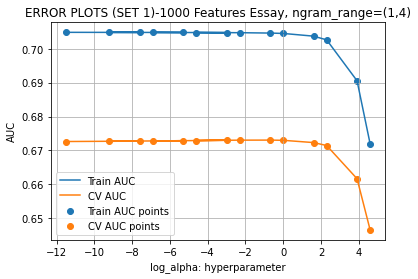

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.92it/s]


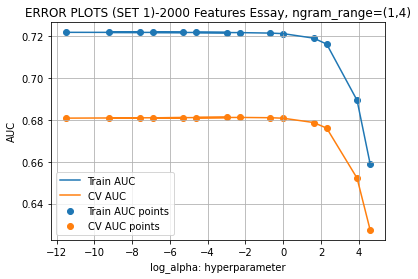

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  6.81it/s]


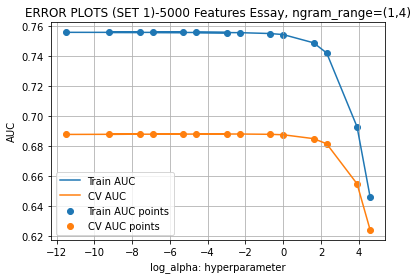

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  6.42it/s]


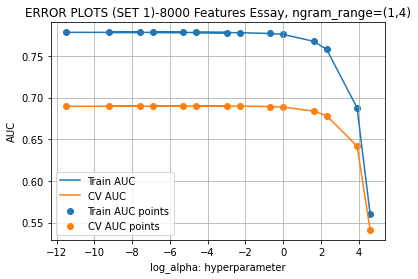

In [ ]:
# Perform Hyperparameter Tuning.
# Plot the training and the CV AUC scores, for different values of 'alpha', using a 2D line plot
from sklearn.naive_bayes import MultinomialNB

#COMPUTE CLASS PROBABILITIES

import math
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

#SET 1
#1000 Features, ngram_range=(1,4)

train_auc = []
cv_auc = []
alpha = [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]
log_alpha=[]
for i in alpha:
    a=math.log(i)
    log_alpha.append(a)

for i in tqdm(alpha):
    mnb = MultinomialNB(alpha=i) #CLASSIFIER
    mnb.fit(X_tr_1, y_train)

    y_train_pred = batch_predict(mnb,X_tr_1)    
    y_cv_pred = batch_predict(mnb,X_cv_1)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(log_alpha, train_auc, label='Train AUC')
plt.plot(log_alpha, cv_auc, label='CV AUC')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log_alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS (SET 1)-1000 Features Essay, ngram_range=(1,4)")
plt.grid()
plt.show()

#SET 1
#2000 Features, ngram_range=(1,4)

train_auc = []
cv_auc = []
alpha = [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]
log_alpha=[]
for i in alpha:
    a=math.log(i)
    log_alpha.append(a)

for i in tqdm(alpha):
    mnb = MultinomialNB(alpha=i) #CLASSIFIER
    mnb.fit(X_tr_2, y_train)

    y_train_pred = batch_predict(mnb, X_tr_2)    
    y_cv_pred = batch_predict(mnb, X_cv_2)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(log_alpha, train_auc, label='Train AUC')
plt.plot(log_alpha, cv_auc, label='CV AUC')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log_alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS (SET 1)-2000 Features Essay, ngram_range=(1,4)")
plt.grid()
plt.show()

#SET 1
#5000 Features, ngram_range=(1,4)

train_auc = []
cv_auc = []
alpha = [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]
log_alpha=[]
for i in alpha:
    a=math.log(i)
    log_alpha.append(a)

for i in tqdm(alpha):
    mnb = MultinomialNB(alpha=i) #CLASSIFIER
    mnb.fit(X_tr_3, y_train)

    y_train_pred = batch_predict(mnb, X_tr_3)    
    y_cv_pred = batch_predict(mnb, X_cv_3)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(log_alpha, train_auc, label='Train AUC')
plt.plot(log_alpha, cv_auc, label='CV AUC')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log_alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS (SET 1)-5000 Features Essay, ngram_range=(1,4)")
plt.grid()
plt.show()

#SET 1
#8000 Features, ngram_range=(1,4)

train_auc = []
cv_auc = []
alpha = [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]
log_alpha=[]
for i in alpha:
    a=math.log(i)
    log_alpha.append(a)

for i in tqdm(alpha):
    mnb = MultinomialNB(alpha=i) #CLASSIFIER
    mnb.fit(X_tr_4, y_train)

    y_train_pred = batch_predict(mnb, X_tr_4)    
    y_cv_pred = batch_predict(mnb, X_cv_4)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(log_alpha, train_auc, label='Train AUC')
plt.plot(log_alpha, cv_auc, label='CV AUC')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log_alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS (SET 1)-8000 Features Essay, ngram_range=(1,4)")
plt.grid()
plt.show()

**1.** The Highest Cross Validation AUC Scores (and least gap b/w Train and CV AUC Curves) of all the number of Text Features are    as   follows-
  * 1000 Features= 0.676
  * 2000 Features= 0.68
  * 5000 Features= 0.686
  * 8000 Features= 0.690
  
**2.** Hence we observe that as the number of features increases, the AUC score also increases slightly. Hence we will take 8101 Features into consideration as it has the highest AUC Score= **0.690**
  * The log_alpha value corresponding to Highest AUC Score and least gap b/w Train and CV AUC of 8099 Features Dataset lies b/w 1.8 and 2.1. Hence we shall take log_alpha=2. 
  * Hence the **Best Alpha= Optimal Hyper parameter= antilog(2)= 7.3**

#### Checking whether changing the number of ngrams results in change of AUC score

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  5.09it/s]


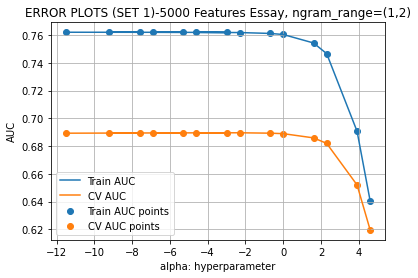

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  7.20it/s]


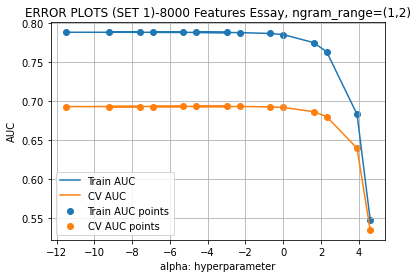

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  6.82it/s]


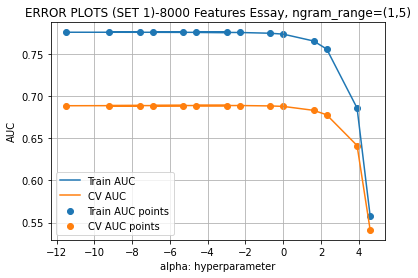

In [ ]:
#SET 1
#5000 Features, ngram_range=(1,2)

train_auc = []
cv_auc = []
alpha = [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]
log_alpha=[]
for i in alpha:
    a=math.log(i)
    log_alpha.append(a)

for i in tqdm(alpha):
    mnb = MultinomialNB(alpha=i) #CLASSIFIER
    mnb.fit(X_tr_e, y_train)

    y_train_pred = batch_predict(mnb, X_tr_e)    
    y_cv_pred = batch_predict(mnb, X_cv_e)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(log_alpha, train_auc, label='Train AUC')
plt.plot(log_alpha, cv_auc, label='CV AUC')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS (SET 1)-5000 Features Essay, ngram_range=(1,2)")
plt.grid()
plt.show()

#SET 1
#8000 Features, ngram_range=(1,2)

train_auc = []
cv_auc = []
alpha = [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]
log_alpha=[]
for i in alpha:
    a=math.log(i)
    log_alpha.append(a)

for i in tqdm(alpha):
    mnb = MultinomialNB(alpha=i) #CLASSIFIER
    mnb.fit(X_tr_f, y_train)

    y_train_pred = batch_predict(mnb, X_tr_f)    
    y_cv_pred = batch_predict(mnb, X_cv_f)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(log_alpha, train_auc, label='Train AUC')
plt.plot(log_alpha, cv_auc, label='CV AUC')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS (SET 1)-8000 Features Essay, ngram_range=(1,2)")
plt.grid()
plt.show()


#SET 1
#8000 Features, ngram_range=(1,5)

train_auc = []
cv_auc = []
alpha = [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]
log_alpha=[]
for i in alpha:
    a=math.log(i)
    log_alpha.append(a)

for i in tqdm(alpha):
    mnb = MultinomialNB(alpha=i) #CLASSIFIER
    mnb.fit(X_tr_g, y_train)

    y_train_pred = batch_predict(mnb, X_tr_g)    
    y_cv_pred = batch_predict(mnb, X_cv_g)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(log_alpha, train_auc, label='Train AUC')
plt.plot(log_alpha, cv_auc, label='CV AUC')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS (SET 1)-8000 Features Essay, ngram_range=(1,5)")
plt.grid()
plt.show()

**1.** We observe that the one with **8101 Features** having ngram_range=(1,2) is giving a higher **AUC score=0.695**. Hence we shall take this dataset for further use.



#### Testing with Fixed Class Priors [0.5,0.5] if it gives a higher AUC Score 

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  6.62it/s]


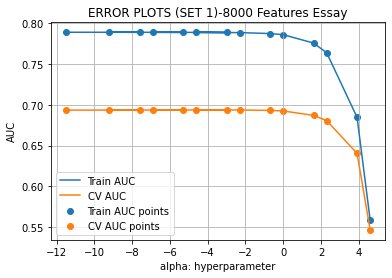

In [ ]:
#SET 1
#8000 Features
#CLASS Priors= [0.5,0.5]

train_auc = []
cv_auc = []
alpha = [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]
log_alpha=[]
for i in alpha:
    a=math.log(i)
    log_alpha.append(a)

for i in tqdm(alpha):
    mnb = MultinomialNB(alpha=i,fit_prior= False, class_prior= [0.5,0.5]) #CLASSIFIER
    mnb.fit(X_tr_f, y_train)

    y_train_pred = batch_predict(mnb, X_tr_f)    
    y_cv_pred = batch_predict(mnb, X_cv_f)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(log_alpha, train_auc, label='Train AUC')
plt.plot(log_alpha, cv_auc, label='CV AUC')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS (SET 1)-8000 Features Essay")
plt.grid()
plt.show()

**1.** We observe that fixing the class priors is not resulting in any significant change in AUC Score. Hence we shall not fix the class priors in our further model.

#### Fitting the Test Data with Best Alpha value and Plotting ROC-AUC Curve

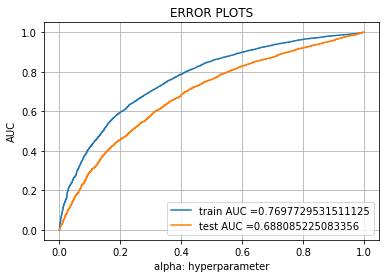

In [ ]:
# Fitting X_test on the optimal alpha value=7.38 and plotting ROC-AUC Curve

mnb = MultinomialNB(alpha=7.38) #CLASSIFIER
mnb.fit(X_tr_f, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(mnb, X_tr_f)    
y_test_pred = batch_predict(mnb, X_te_f)

train_fpr_1, train_tpr_1, tr_thresholds_1 = roc_curve(y_train, y_train_pred)
test_fpr_1, test_tpr_1, te_thresholds_1 = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr_1, train_tpr_1, label="train AUC ="+str(auc(train_fpr_1, train_tpr_1)))
plt.plot(test_fpr_1, test_tpr_1, label="test AUC ="+str(auc(test_fpr_1, test_tpr_1)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

### OBSERVATION

* The **Train AUC Score= 0.769** and **Test AUC Score= 0.688** (for the chosen number of Features=8101) for the best value of **Alpha= 7.38**

#### Calculation of Best Threshold Value 

In [ ]:
#Best Threshold Value that will give the least TPR(1-FPR)
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("The maximum value of TPR*(1-FPR)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

### CONFUSION MATRIX of SET 1 using Best Threshold Value

In [ ]:
#CONSUFION MATRIX USING BEST THRESHOLD
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds_1, train_fpr_1, train_tpr_1)
print("Train confusion matrix")
a=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
print(a)
print("-"*100)
print("Test confusion matrix")
b= confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
print(b)
print("="*100)

The maximum value of TPR*(1-FPR) 0.5036999221583175 for threshold 0.842
Train confusion matrix
[[ 2611   984]
 [ 5777 13073]]
----------------------------------------------------------------------------------------------------
Test confusion matrix
[[1587 1055]
 [4478 9380]]


* Hence the best threshold that coprresponds to the highest value of TPR(1-FPR)= **0.842**

# SET 2- All Categorical + Numerical Features + TFIDF Vector of Essay

#### Hyper Parameter Tuning 

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.93it/s]


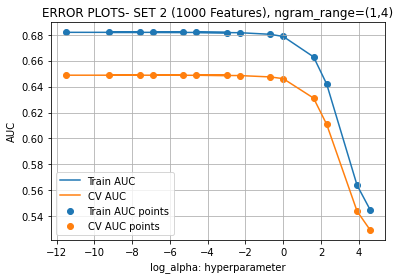

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  8.84it/s]


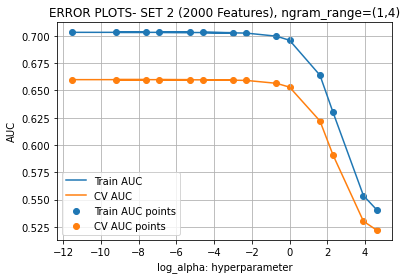

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  6.55it/s]


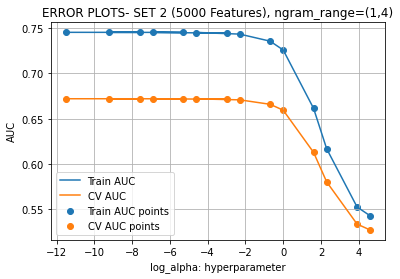

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  6.33it/s]


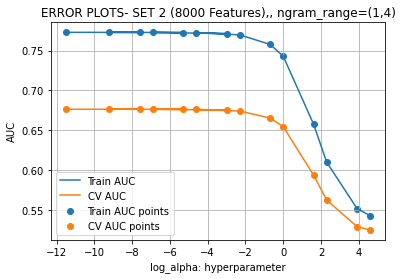

In [ ]:
#1000 Features, ngram_range=(1,4)

train_auc = []
cv_auc = []
alpha = [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]
log_alpha=[]
for i in alpha:
    a=math.log(i)
    log_alpha.append(a)

for i in tqdm(alpha):
    mnb = MultinomialNB(alpha=i) #CLASSIFIER
    mnb.fit(X_tr_5, y_train)

    y_train_pred = batch_predict(mnb, X_tr_5)    
    y_cv_pred = batch_predict(mnb, X_cv_5)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(log_alpha, train_auc, label='Train AUC')
plt.plot(log_alpha, cv_auc, label='CV AUC')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log_alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS- SET 2 (1000 Features), ngram_range=(1,4)")
plt.grid()
plt.show()

#2000 Features, ngram_range=(1,4)

train_auc = []
cv_auc = []
alpha = [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]
log_alpha=[]
for i in alpha:
    a=math.log(i)
    log_alpha.append(a)

for i in tqdm(alpha):
    mnb = MultinomialNB(alpha=i) #CLASSIFIER
    mnb.fit(X_tr_6, y_train)

    y_train_pred = batch_predict(mnb, X_tr_6)    
    y_cv_pred = batch_predict(mnb, X_cv_6)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(log_alpha, train_auc, label='Train AUC')
plt.plot(log_alpha, cv_auc, label='CV AUC')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log_alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS- SET 2 (2000 Features), ngram_range=(1,4)")
plt.grid()
plt.show()

#5000 Features, ngram_range=(1,4)

train_auc = []
cv_auc = []
alpha = [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]
log_alpha=[]
for i in alpha:
    a=math.log(i)
    log_alpha.append(a)

for i in tqdm(alpha):
    mnb = MultinomialNB(alpha=i) #CLASSIFIER
    mnb.fit(X_tr_7, y_train)

    y_train_pred = batch_predict(mnb, X_tr_7)    
    y_cv_pred = batch_predict(mnb, X_cv_7)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(log_alpha, train_auc, label='Train AUC')
plt.plot(log_alpha, cv_auc, label='CV AUC')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log_alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS- SET 2 (5000 Features), ngram_range=(1,4)")
plt.grid()
plt.show()

#8000 Features, ngram_range=(1,4)

train_auc = []
cv_auc = []
alpha = [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]
log_alpha=[]
for i in alpha:
    a=math.log(i)
    log_alpha.append(a)

for i in tqdm(alpha):
    mnb = MultinomialNB(alpha=i) #CLASSIFIER
    mnb.fit(X_tr_8, y_train)

    y_train_pred = batch_predict(mnb, X_tr_8)    
    y_cv_pred = batch_predict(mnb, X_cv_8)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(log_alpha, train_auc, label='Train AUC')
plt.plot(log_alpha, cv_auc, label='CV AUC')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log_alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS- SET 2 (8000 Features),, ngram_range=(1,4)")
plt.grid()
plt.show()

**1.** The Highest Cross Validation AUC Scores (and least gap b/w Train and CV AUC Curves) of all the number of Text Features are    as   follows-
  * 1101 Features= 0.65
  * 2101 Features= 0.66
  * 5101 Features= 0.674
  * 8101 Features= 0.675
  
**2.** Hence we observe that as the number of features increases, the AUC score also increases slightly in this case. Hence we will take 8099 Features into consideration as it has the highest AUC Score= **0.675**
  * The log_alpha value corresponding to Highest AUC Score and least gap b/w Train and CV AUC of 8099 Features Dataset is -2.2. Hence we shall take log_alpha=-2.2. 
  * Hence the **Best Alpha= Optimal Hyper parameter= antilog(-2.2)= 0.11**

##### Checking whether changing the number of ngrams results in change of AUC score

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  7.06it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  7.04it/s]


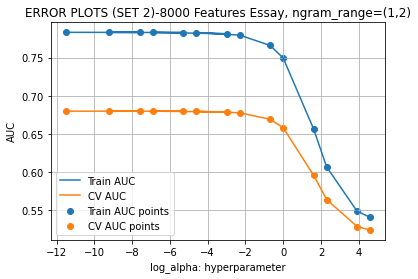

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  6.81it/s]


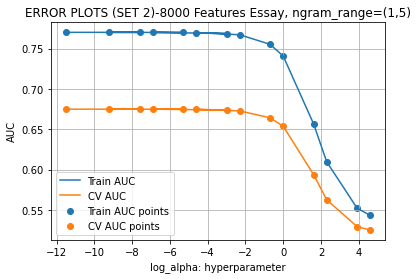

In [ ]:
#SET 2
#5000 Features ESSAY, ngram_range=(1,2)

train_auc = []
cv_auc = []
alpha = [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]
log_alpha=[]
for i in alpha:
    a=math.log(i)
    log_alpha.append(a)

for i in tqdm(alpha):
    mnb = MultinomialNB(alpha=i) #CLASSIFIER
    mnb.fit(X_tr_x, y_train)

    y_train_pred = batch_predict(mnb, X_tr_x)    
    y_cv_pred = batch_predict(mnb, X_cv_x)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(log_alpha, train_auc, label='Train AUC')
plt.plot(log_alpha, cv_auc, label='CV AUC')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log_alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS (SET 2)-5000 Features Essay, ngram_range=(1,2)")
plt.grid()
plt.show()

#SET 2 
#8000 Features ESSAY, ngram_range=(1,2)

train_auc = []
cv_auc = []
alpha = [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]
log_alpha=[]
for i in alpha:
    a=math.log(i)
    log_alpha.append(a)

for i in tqdm(alpha):
    mnb = MultinomialNB(alpha=i) #CLASSIFIER
    mnb.fit(X_tr_y, y_train)

    y_train_pred = batch_predict(mnb, X_tr_y)    
    y_cv_pred = batch_predict(mnb, X_cv_y)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(log_alpha, train_auc, label='Train AUC')
plt.plot(log_alpha, cv_auc, label='CV AUC')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log_alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS (SET 2)-8000 Features Essay, ngram_range=(1,2)")
plt.grid()
plt.show()


#SET 2
#8000 Features ESSAY, ngram_range=(1,5)

train_auc = []
cv_auc = []
alpha = [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]
log_alpha=[]
for i in alpha:
    a=math.log(i)
    log_alpha.append(a)

for i in tqdm(alpha):
    mnb = MultinomialNB(alpha=i) #CLASSIFIER
    mnb.fit(X_tr_z, y_train)

    y_train_pred = batch_predict(mnb, X_tr_z)    
    y_cv_pred = batch_predict(mnb, X_cv_z)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(log_alpha, train_auc, label='Train AUC')
plt.plot(log_alpha, cv_auc, label='CV AUC')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log_alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS (SET 2)-8000 Features Essay, ngram_range=(1,5)")
plt.grid()
plt.show()

**1.** Here also we observe that the one with **8101 Features** having ngram_range=(1,2) is giving a higher **AUC score=0.676**. Hence we shall take this dataset for further use.


#### Testing with Fixed Class Priors [0.5,0.5] if it gives a higher AUC Score 

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  5.78it/s]


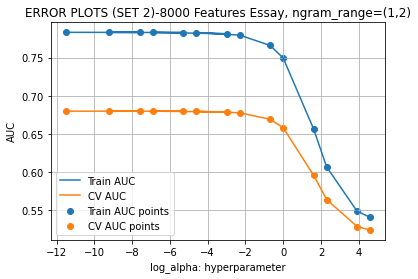

In [ ]:
#SET 2
#8000 Features ESSAY
#CLASS Priors= [o.5,0.5]

train_auc = []
cv_auc = []
alpha = [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]
log_alpha=[]
for i in alpha:
    a=math.log(i)
    log_alpha.append(a)

for i in tqdm(alpha):
    mnb = MultinomialNB(alpha=i,fit_prior= False, class_prior= [0.5,0.5]) #CLASSIFIER
    mnb.fit(X_tr_y, y_train)

    y_train_pred = batch_predict(mnb, X_tr_y)    
    y_cv_pred = batch_predict(mnb, X_cv_y)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(log_alpha, train_auc, label='Train AUC')
plt.plot(log_alpha, cv_auc, label='CV AUC')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log_alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS (SET 2)-8000 Features Essay, ngram_range=(1,2)")
plt.grid()
plt.show()

**1.** We observe that fixing the class priors is not resulting in any significant change in AUC Score. Hence we shall not fix the class priors in our further model.

#### Fitting the Test Data with Best Alpha value and Plotting ROC-AUC Curve

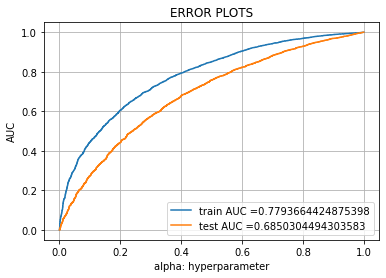

In [ ]:
# Fitting X_test on the optimal alpha value=0.11 and plotting ROC-AUC Curve

mnb = MultinomialNB(alpha=0.11) #CLASSIFIER
mnb.fit(X_tr_y, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(mnb, X_tr_y)    
y_test_pred = batch_predict(mnb, X_te_y)

train_fpr_2, train_tpr_2, tr_thresholds_2 = roc_curve(y_train, y_train_pred)
test_fpr_2, test_tpr_2, te_thresholds_2 = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr_2, train_tpr_2, label="train AUC ="+str(auc(train_fpr_2, train_tpr_2)))
plt.plot(test_fpr_2, test_tpr_2, label="test AUC ="+str(auc(test_fpr_2, test_tpr_2)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

### OBSERVATION

* The **Train AUC Score= 0.779** and **Test AUC Score= 0.685** (for the chosen number of Features=8101) for the best value of **Alpha= 0.11**

### CONFUSION MATRIX using  Best threshold Value

In [ ]:
#CONSUFION MATRIX USING BEST THRESHOLD
best_t_2 = find_best_threshold(tr_thresholds_2, train_fpr_2, train_tpr_2)
print("Train confusion matrix")
c=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t_2))
print(c)
print("-"*100)
print("Test confusion matrix")
d= confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t_2))
print(d)
print("="*100)

The maximum value of TPR*(1-FPR) 0.5036999221583175 for threshold 0.842
Train confusion matrix
[[ 2611   984]
 [ 5777 13073]]
----------------------------------------------------------------------------------------------------
Test confusion matrix
[[1587 1055]
 [4478 9380]]


* Hence the best threshold that coprresponds to the highest value of TPR(1-FPR)= **0.842**

### HEAT MAP of Confusion Matrix of Test Data of Set 1 and Set 2 

Set 1


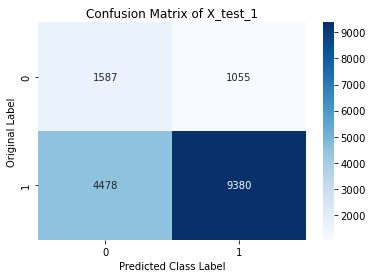

----------------------------------------------------------------------------------------------------
Set 2


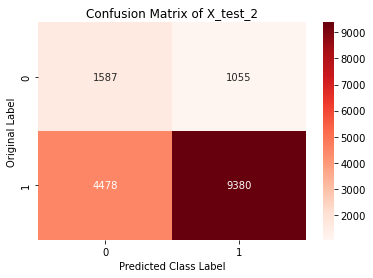

In [ ]:
import seaborn as sns

#SET 1
print('Set 1')
sns.heatmap(data=b, annot=True,cmap='Blues',fmt='d')
plt.title("Confusion Matrix of X_test_1")
plt.xlabel("Predicted Class Label")
plt.ylabel("Original Label")
plt.show()
print('-'*100)

#SET 2
print('Set 2')
sns.heatmap(data=d, annot=True,cmap='Reds',fmt='d')
plt.title("Confusion Matrix of X_test_2")
plt.xlabel("Predicted Class Label")
plt.ylabel("Original Label")
plt.show()
print('='*100)

# 2.8 Top 20 Features

In [ ]:
#Creating another dataset with only train data to get top features.

#Text Feature
l=[] 
X_train_essay_bow_f = vectorizer_y.transform(X_train['essay'].values)
A=list(vectorizer_4.get_feature_names())
l.extend(A)

#Categorical Features
vectorizer = CountVectorizer(binary=True)
school_state_ohe_train = vectorizer.fit_transform(X_train['school_state'].values)
B=list(vectorizer.get_feature_names())
l.extend(B)
teacher_prefix_ohe_train= vectorizer.fit_transform(X_train['teacher_prefix'].values)
C=list(vectorizer.get_feature_names())
l.extend(C)
project_grade_category_ohe_train= vectorizer.fit_transform(X_train['project_grade_category'].values)
D=list(vectorizer.get_feature_names())
l.extend(D)
clean_categories_ohe_train= vectorizer.fit_transform(X_train['clean_categories'].values)
E=list(vectorizer.get_feature_names())
l.extend(E)
clean_subcategories_ohe_train= vectorizer.fit_transform(X_train['clean_subcategories'].values)
F=list(vectorizer.get_feature_names())
l.extend(F)

#Numerical Features
normalizer = Normalizer()
X_train_tnppp_norm= normalizer.fit_transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
G=X_train_tnppp_norm
l.append(G)

X_train_price_norm= normalizer.fit_transform(X_train['price'].values.reshape(-1,1))
H=X_train_price_norm
l.append(H)
Data = hstack((X_train_essay_bow_f, school_state_ohe_train, teacher_prefix_ohe_train, project_grade_category_ohe_train, clean_categories_ohe_train,clean_subcategories_ohe_train,X_train_tnppp_norm,X_train_price_norm)).tocsr()

#### Since the Test AUC of SET 1 is slightly higher than that of SET 2, we will consider SET 1 to print the Top 20 features.

In [ ]:
D= mnb.fit(Data,y_train)
Positive= D.feature_log_prob_[1]
Negative= D.feature_log_prob_[0]
p_indices=np.argsort(Positive)[::-1][:20]
n_indices=np.argsort(Negative)[::-1][:20]
L1=[] #To append Feature Names for Positive Class
for i in p_indices:
  L1.append(l[i]) 
L0=[] #To append Feature Names for Negative Class
for i in n_indices:
  L0.append(l[i]) 
print('Class 1: ',L1)
print('-'*100)
print('Class 0: ',L0)
print('='*100)

Class 1:  ['students come', 'school north', 'my students love', 'classroom we', 'lesson', 'the carpet', 'not let', 'these magazines', 'learning center', 'my students would', 'higher education', array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]]), 'materials help students', 'nannan', 'way nannan', 'wonderful students', 'receive backpack', 'need access', 'upcoming school', 'designated']
----------------------------------------------------------------------------------------------------
Class 0:  ['students come', 'school north', 'lesson', 'my students love', 'classroom we', 'not let', 'learning center', 'the carpet', 'these magazines', 'higher education', 'my students would', array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]]), 'nannan', 'materials help students', 'way nannan', 'need access', 'wonderful students', 'compassion', 'ability', 'written']


# 3.0 SUMMARY

The Final Results of the above assignment are printed below

In [ ]:
#Summary in a table

from prettytable import PrettyTable
table=PrettyTable(['Vectorizer','Model','Number of Features','ngram_range(of text)','Class Prior(Fixed/NotFixed)','Hyperparameter','TestAUC'])
table.add_row(['BOW','NaiveBayes',8101,'(1,2)','NotFixed','Alpha= 7.38', 0.688 ])
table.add_row(['TFIDF','Naive Bayes',8101,'(1,2)','NotFixed','Alpha=0.11',0.685])
print(table)

+------------+-------------+--------------------+----------------------+-----------------------------+----------------+---------+
| Vectorizer |    Model    | Number of Features | ngram_range(of text) | Class Prior(Fixed/NotFixed) | Hyperparameter | TestAUC |
+------------+-------------+--------------------+----------------------+-----------------------------+----------------+---------+
|    BOW     |  NaiveBayes |        8101        |        (1,2)         |           NotFixed          |  Alpha= 7.38   |  0.688  |
|   TFIDF    | Naive Bayes |        8101        |        (1,2)         |           NotFixed          |   Alpha=0.11   |  0.685  |
+------------+-------------+--------------------+----------------------+-----------------------------+----------------+---------+


**Hence both BOW and TFIDF have given almost the same AUC Score for MultinomialNB Model.**